In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
df = pd.read_csv('PUBG_Game_Prediction_data.csv')

In [3]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
df.shape

(4446966, 29)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [7]:
df.drop(2744604,inplace=True)

In [8]:
#prepare new parameter to know how many player in game
df['playerjoiend'] = df.groupby('matchId')['matchId'].transform('count')

In [9]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playerjoiend
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


<b><h2>Hacker in the game</h2></b>

In [10]:
#total distance travell in the game 

df['totaldistance'] = df['rideDistance']+df['walkDistance'] +df['swimDistance'] 

In [11]:
#person is not move but still is killing

df['killswithoutmoving'] = ((df['kills'] >0) & (df['totaldistance']== 0))

In [12]:
df.drop(df[df['killswithoutmoving'] == True].index , inplace = True )

In [13]:
#extra road kills 

df.drop(df[df['roadKills']>5].index, inplace=True)

<Axes: xlabel='kills', ylabel='count'>

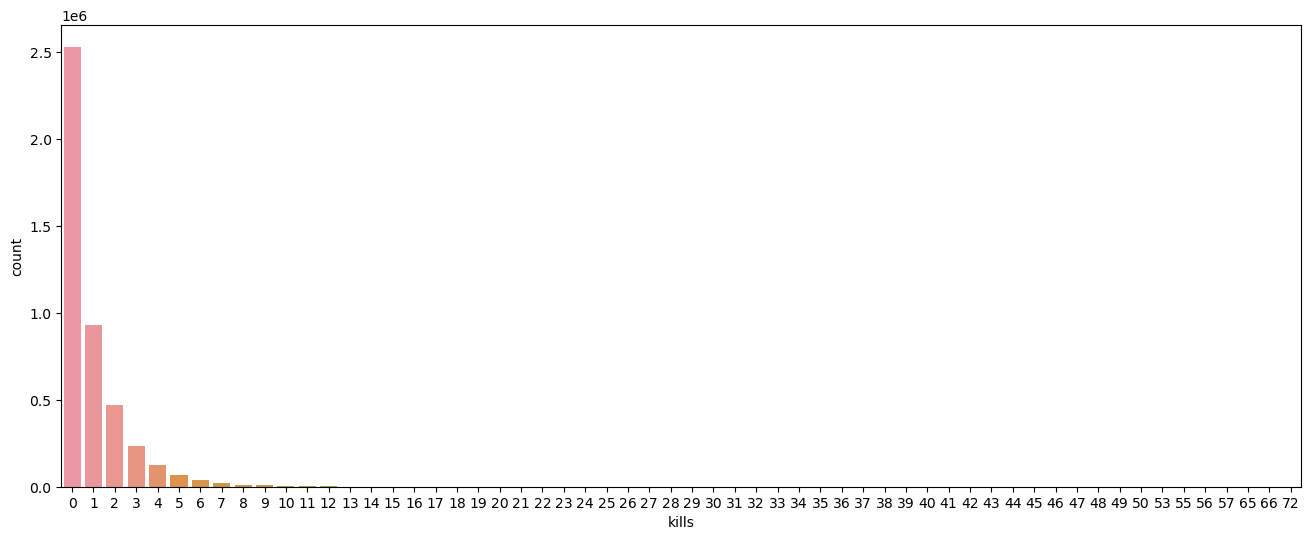

In [14]:
sns.countplot(x='kills',data = df)

In [15]:
df.drop(df[df['kills']>20].index,inplace=True)

In [16]:
#headshot rate
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

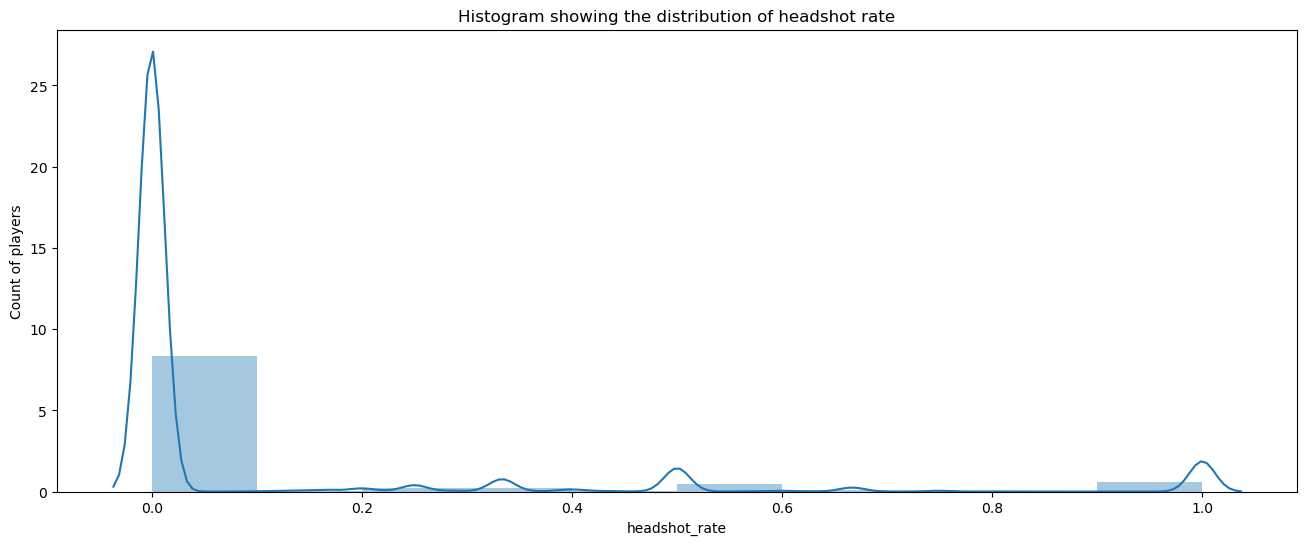

In [17]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins =10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [18]:
df.drop(df[(df['headshot_rate'] == 1)& (df['kills'] > 6)].index, inplace = True)


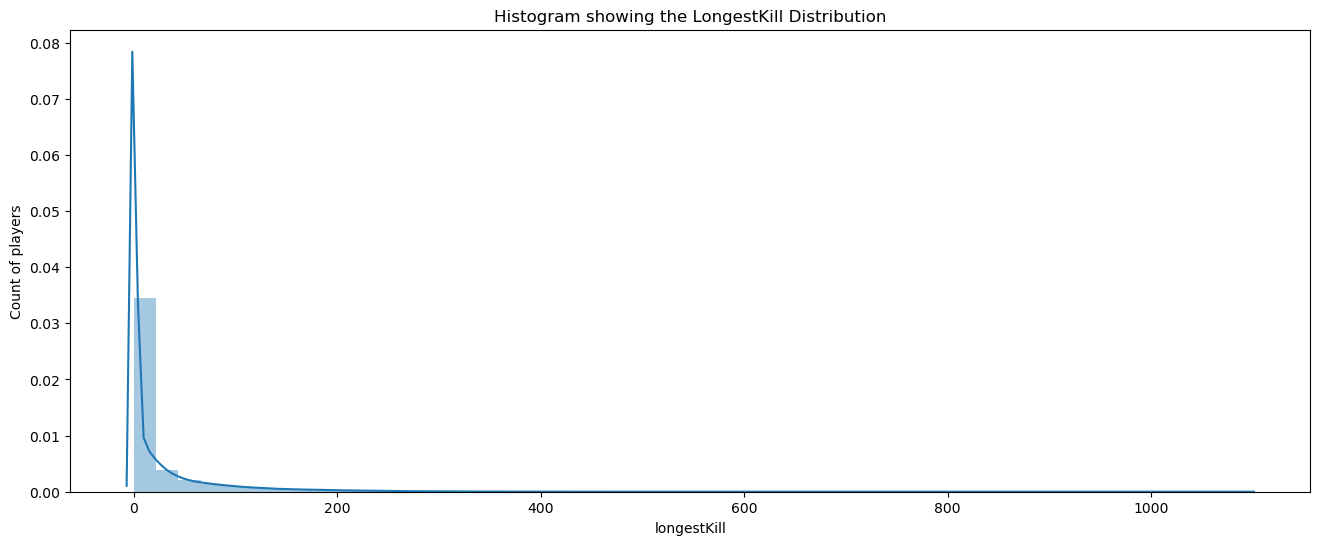

In [19]:
#longshot 

sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the LongestKill Distribution")
plt.ylabel("Count of players")
plt.show()

In [20]:
df.drop(df[df['longestKill']>=500].index, inplace = True)

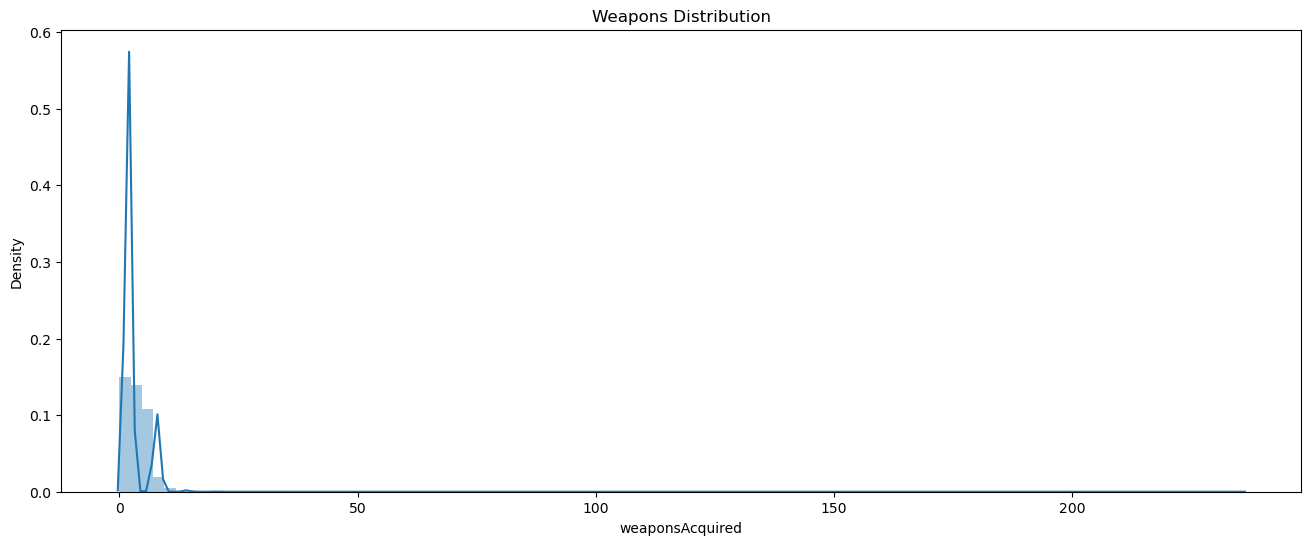

In [21]:
#weapon change

sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [22]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

In [23]:
df.shape

(4436306, 33)

In [24]:
df.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playerjoiend          0
totaldistance         0
killswithoutmoving    0
headshot_rate         0
dtype: int64

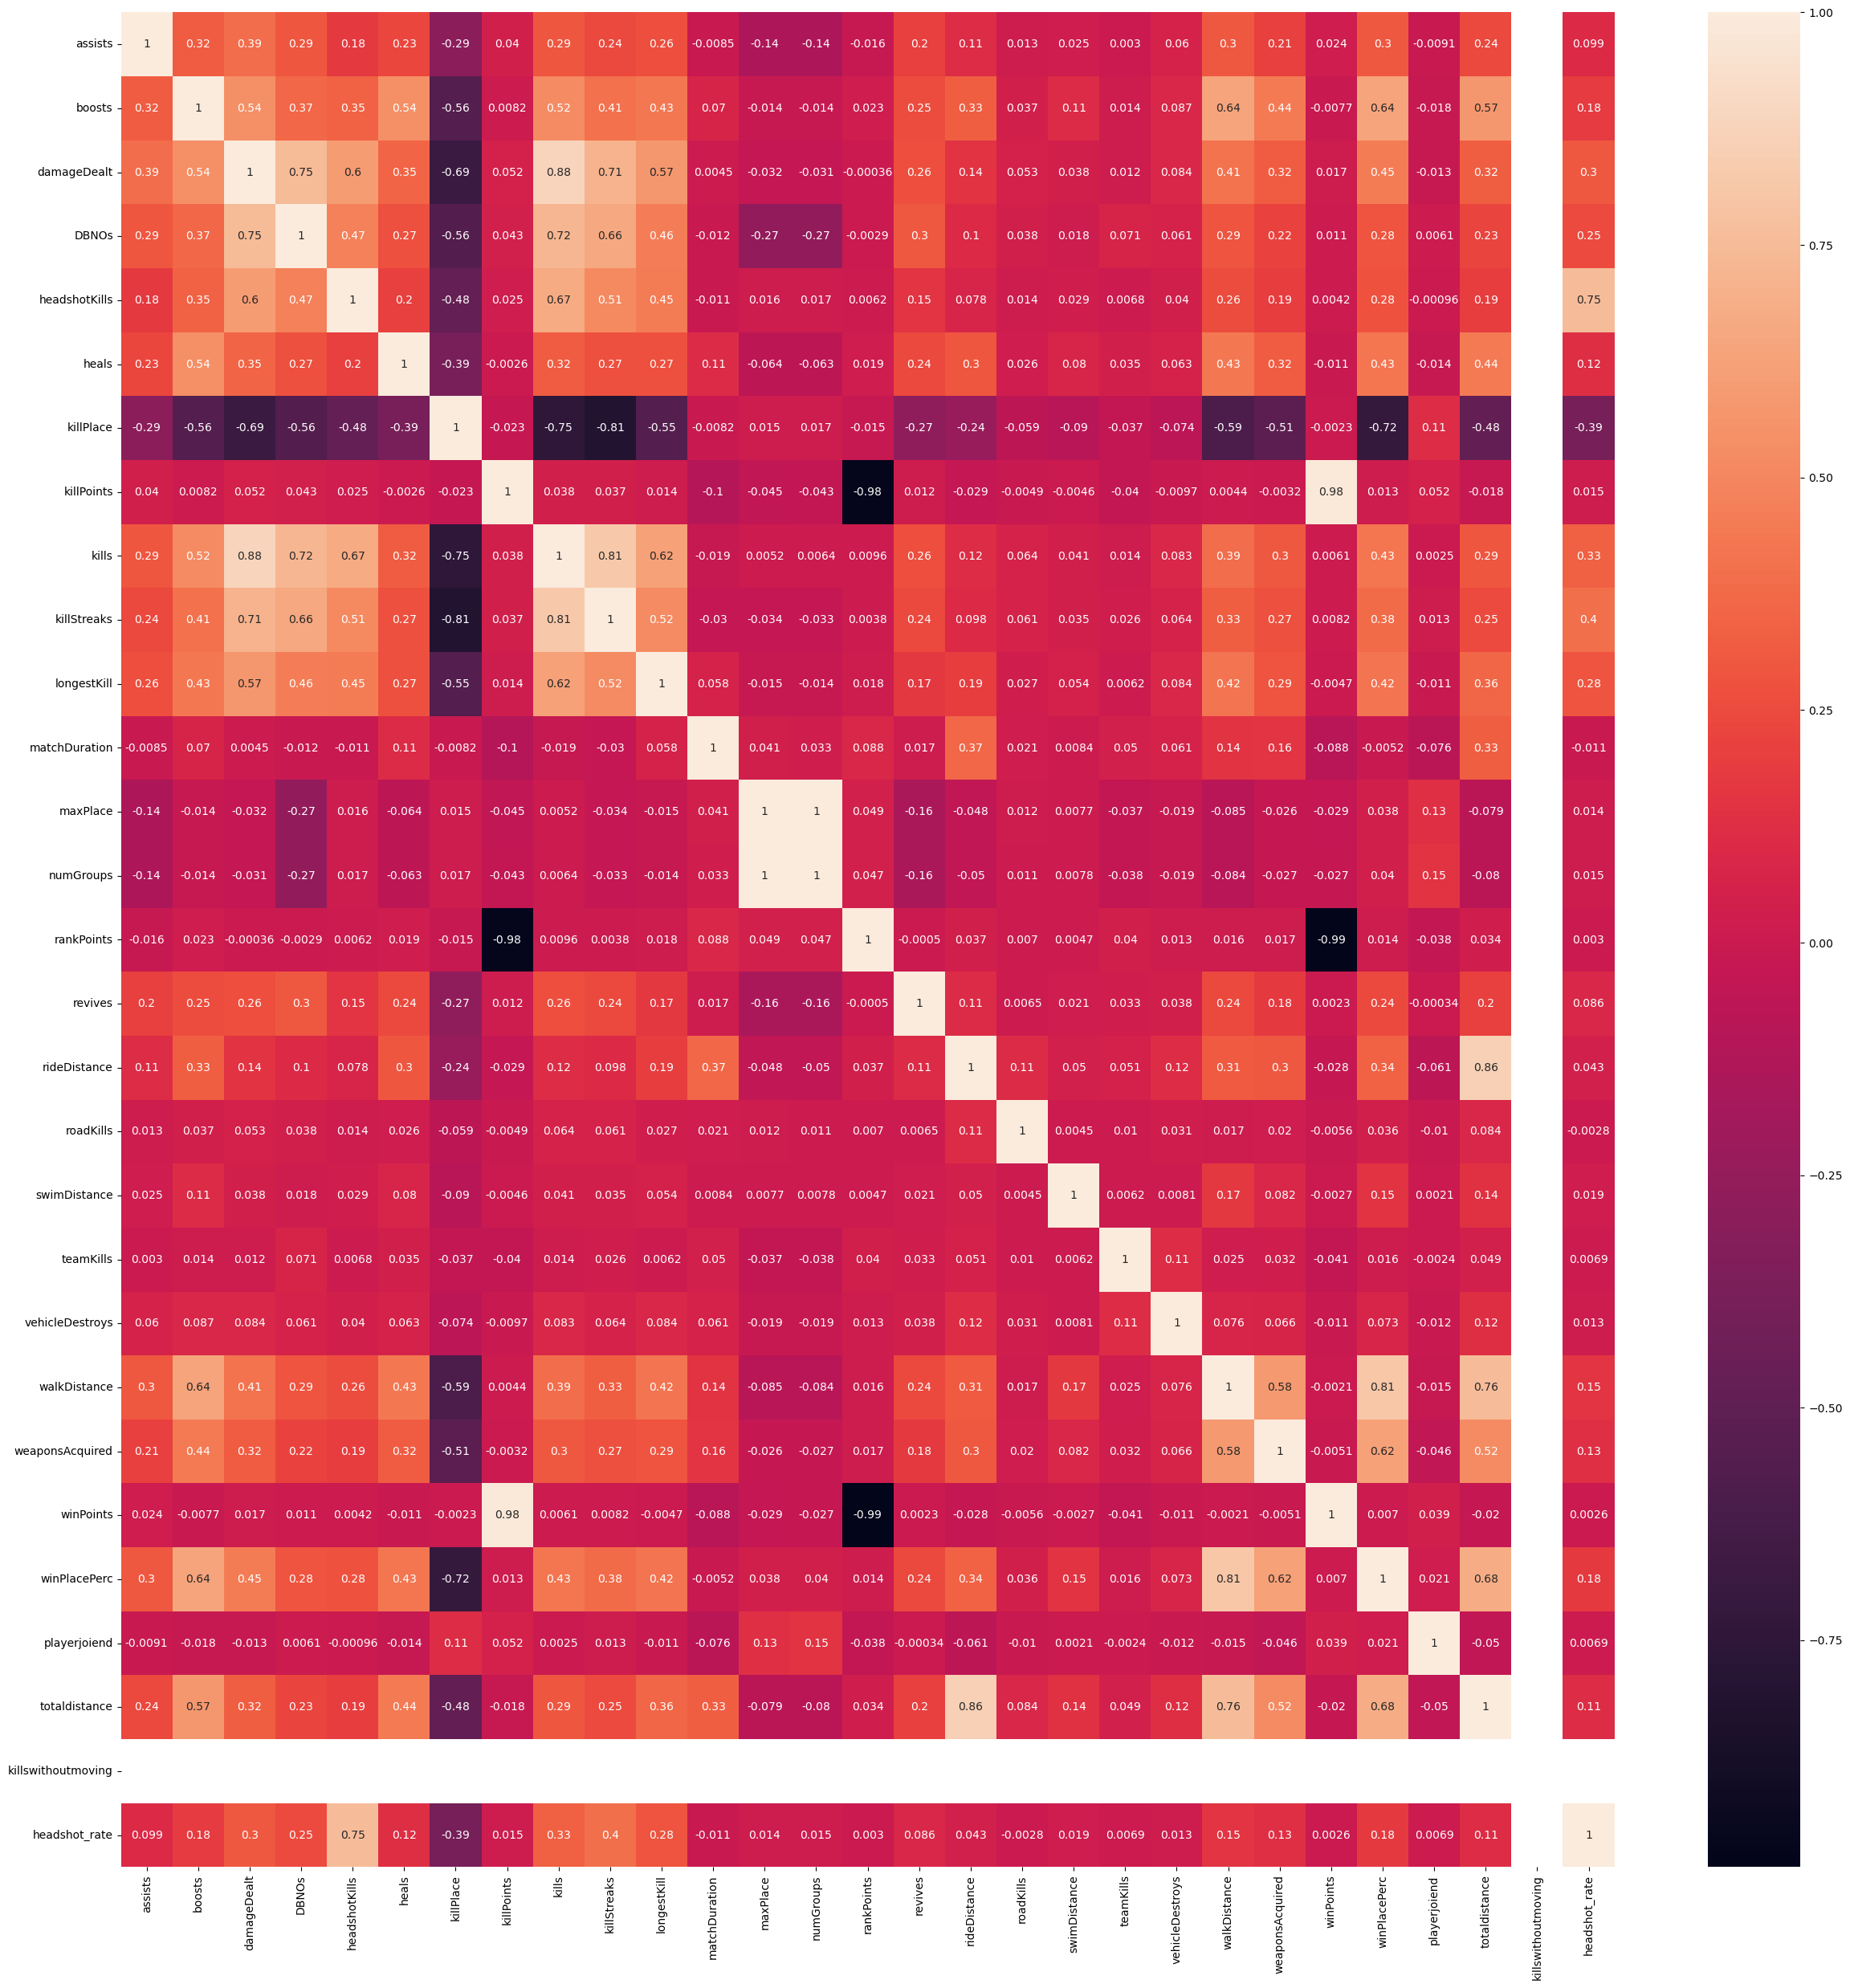

In [25]:
# correlation of parameter with Win Prediction
plt.figure(figsize=[30,30])
sns.heatmap(df.corr(), annot = True)
plt.show()

<b><h2>Feature engineering </h2></b>

In [28]:
normalising_factor = (100 - df['playerjoiend']/100)+1

In [29]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor


df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [30]:
data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance', 
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])


<b><h2> Modeling </h2></b>

In [31]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [33]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutmoving'])

In [36]:
features = x.columns

In [40]:
#Scaling the data

sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [41]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


In [67]:
#Splitting data

xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size = 0.2, random_state = 10)

In [68]:
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [69]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [70]:
# GRID Search

grid = {'iterations': [100, 10], 
       'learning_rate': [0.03, 0.1,0.2], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482240	test: 0.5482588	best: 0.5482588 (0)	total: 505ms	remaining: 50s
1:	learn: 0.5333780	test: 0.5334149	best: 0.5334149 (1)	total: 996ms	remaining: 48.8s
2:	learn: 0.5190085	test: 0.5190469	best: 0.5190469 (2)	total: 1.52s	remaining: 49.1s
3:	learn: 0.5051057	test: 0.5051460	best: 0.5051460 (3)	total: 2.04s	remaining: 49.1s
4:	learn: 0.4916414	test: 0.4916804	best: 0.4916804 (4)	total: 2.53s	remaining: 48.1s
5:	learn: 0.4786282	test: 0.4786636	best: 0.4786636 (5)	total: 3.04s	remaining: 47.6s
6:	learn: 0.4660199	test: 0.4660555	best: 0.4660555 (6)	total: 3.53s	remaining: 46.9s
7:	learn: 0.4538421	test: 0.4538799	best: 0.4538799 (7)	total: 4.02s	remaining: 46.3s
8:	learn: 0.4420602	test: 0.4421009	best: 0.4421009 (8)	total: 4.53s	remaining: 45.8s
9:	learn: 0.4306156	test: 0.4306584	best: 0.4306584 (9)	total: 5.05s	remaining: 45.4s
10:	learn: 0.4195587	test: 0.4196038	best: 0.4196038 (10)	total: 5.56s	remaining: 45s
11:	learn: 0.4089187	test: 0.4089668	best: 0.4089668 (11

94:	learn: 0.1399277	test: 0.1400802	best: 0.1400802 (94)	total: 35.7s	remaining: 1.88s
95:	learn: 0.1395404	test: 0.1396931	best: 0.1396931 (95)	total: 35.9s	remaining: 1.49s
96:	learn: 0.1391691	test: 0.1393231	best: 0.1393231 (96)	total: 36.2s	remaining: 1.12s
97:	learn: 0.1388005	test: 0.1389559	best: 0.1389559 (97)	total: 36.4s	remaining: 743ms
98:	learn: 0.1384019	test: 0.1385588	best: 0.1385588 (98)	total: 36.6s	remaining: 370ms
99:	learn: 0.1380646	test: 0.1382219	best: 0.1382219 (99)	total: 36.8s	remaining: 0us

bestTest = 0.1382219089
bestIteration = 99

0:	loss: 0.1382219	best: 0.1382219 (0)	total: 42.8s	remaining: 16m 24s
0:	learn: 0.5125857	test: 0.5126192	best: 0.5126192 (0)	total: 222ms	remaining: 22s
1:	learn: 0.4671207	test: 0.4671501	best: 0.4671501 (1)	total: 482ms	remaining: 23.6s
2:	learn: 0.4265204	test: 0.4265586	best: 0.4265586 (2)	total: 782ms	remaining: 25.3s
3:	learn: 0.3903866	test: 0.3904331	best: 0.3904331 (3)	total: 1.11s	remaining: 26.6s
4:	learn: 0.3581

87:	learn: 0.1176009	test: 0.1177850	best: 0.1177850 (87)	total: 24.3s	remaining: 3.32s
88:	learn: 0.1172640	test: 0.1174488	best: 0.1174488 (88)	total: 24.6s	remaining: 3.04s
89:	learn: 0.1169497	test: 0.1171373	best: 0.1171373 (89)	total: 24.9s	remaining: 2.76s
90:	learn: 0.1167938	test: 0.1169830	best: 0.1169830 (90)	total: 25.1s	remaining: 2.49s
91:	learn: 0.1166974	test: 0.1168856	best: 0.1168856 (91)	total: 25.4s	remaining: 2.21s
92:	learn: 0.1165644	test: 0.1167525	best: 0.1167525 (92)	total: 25.6s	remaining: 1.93s
93:	learn: 0.1164800	test: 0.1166658	best: 0.1166658 (93)	total: 25.9s	remaining: 1.65s
94:	learn: 0.1163748	test: 0.1165604	best: 0.1165604 (94)	total: 26.1s	remaining: 1.38s
95:	learn: 0.1162944	test: 0.1164803	best: 0.1164803 (95)	total: 26.4s	remaining: 1.1s
96:	learn: 0.1162143	test: 0.1164007	best: 0.1164007 (96)	total: 26.6s	remaining: 823ms
97:	learn: 0.1161198	test: 0.1163054	best: 0.1163054 (97)	total: 26.8s	remaining: 548ms
98:	learn: 0.1160452	test: 0.1162

80:	learn: 0.1072246	test: 0.1074240	best: 0.1074240 (80)	total: 19.5s	remaining: 4.58s
81:	learn: 0.1071287	test: 0.1073273	best: 0.1073273 (81)	total: 19.7s	remaining: 4.33s
82:	learn: 0.1070217	test: 0.1072228	best: 0.1072228 (82)	total: 19.9s	remaining: 4.08s
83:	learn: 0.1066646	test: 0.1068639	best: 0.1068639 (83)	total: 20.2s	remaining: 3.85s
84:	learn: 0.1065237	test: 0.1067252	best: 0.1067252 (84)	total: 20.4s	remaining: 3.6s
85:	learn: 0.1062962	test: 0.1064985	best: 0.1064985 (85)	total: 20.7s	remaining: 3.37s
86:	learn: 0.1060713	test: 0.1062749	best: 0.1062749 (86)	total: 21s	remaining: 3.13s
87:	learn: 0.1058922	test: 0.1061012	best: 0.1061012 (87)	total: 21.2s	remaining: 2.89s
88:	learn: 0.1058147	test: 0.1060230	best: 0.1060230 (88)	total: 21.4s	remaining: 2.65s
89:	learn: 0.1056713	test: 0.1058828	best: 0.1058828 (89)	total: 21.7s	remaining: 2.41s
90:	learn: 0.1055233	test: 0.1057355	best: 0.1057355 (90)	total: 21.9s	remaining: 2.17s
91:	learn: 0.1054334	test: 0.105645

40:	learn: 0.2070934	test: 0.2072038	best: 0.2072038 (40)	total: 13.8s	remaining: 19.8s
41:	learn: 0.2031838	test: 0.2032929	best: 0.2032929 (41)	total: 14.1s	remaining: 19.5s
42:	learn: 0.1995197	test: 0.1996318	best: 0.1996318 (42)	total: 14.5s	remaining: 19.2s
43:	learn: 0.1959258	test: 0.1960377	best: 0.1960377 (43)	total: 14.8s	remaining: 18.9s
44:	learn: 0.1925321	test: 0.1926466	best: 0.1926466 (44)	total: 15.2s	remaining: 18.6s
45:	learn: 0.1892363	test: 0.1893527	best: 0.1893527 (45)	total: 15.5s	remaining: 18.3s
46:	learn: 0.1861030	test: 0.1862222	best: 0.1862222 (46)	total: 15.9s	remaining: 17.9s
47:	learn: 0.1831182	test: 0.1832421	best: 0.1832421 (47)	total: 16.2s	remaining: 17.6s
48:	learn: 0.1802376	test: 0.1803647	best: 0.1803647 (48)	total: 16.6s	remaining: 17.3s
49:	learn: 0.1773431	test: 0.1774696	best: 0.1774696 (49)	total: 17s	remaining: 17s
50:	learn: 0.1746867	test: 0.1748168	best: 0.1748168 (50)	total: 17.3s	remaining: 16.6s
51:	learn: 0.1720190	test: 0.1721484

33:	learn: 0.1156873	test: 0.1159205	best: 0.1159205 (33)	total: 11.3s	remaining: 21.9s
34:	learn: 0.1145653	test: 0.1148007	best: 0.1148007 (34)	total: 11.6s	remaining: 21.6s
35:	learn: 0.1137414	test: 0.1139770	best: 0.1139770 (35)	total: 12s	remaining: 21.3s
36:	learn: 0.1130986	test: 0.1133403	best: 0.1133403 (36)	total: 12.3s	remaining: 21s
37:	learn: 0.1125864	test: 0.1128280	best: 0.1128280 (37)	total: 12.6s	remaining: 20.6s
38:	learn: 0.1121303	test: 0.1123725	best: 0.1123725 (38)	total: 12.9s	remaining: 20.2s
39:	learn: 0.1114459	test: 0.1116868	best: 0.1116868 (39)	total: 13.2s	remaining: 19.9s
40:	learn: 0.1110336	test: 0.1112763	best: 0.1112763 (40)	total: 13.5s	remaining: 19.5s
41:	learn: 0.1103886	test: 0.1106228	best: 0.1106228 (41)	total: 13.9s	remaining: 19.1s
42:	learn: 0.1100763	test: 0.1103077	best: 0.1103077 (42)	total: 14.1s	remaining: 18.7s
43:	learn: 0.1094122	test: 0.1096429	best: 0.1096429 (43)	total: 14.5s	remaining: 18.4s
44:	learn: 0.1087506	test: 0.1089740

26:	learn: 0.1055763	test: 0.1057459	best: 0.1057459 (26)	total: 10.2s	remaining: 27.5s
27:	learn: 0.1047562	test: 0.1049175	best: 0.1049175 (27)	total: 10.5s	remaining: 27.1s
28:	learn: 0.1043231	test: 0.1044847	best: 0.1044847 (28)	total: 10.8s	remaining: 26.5s
29:	learn: 0.1037252	test: 0.1038888	best: 0.1038888 (29)	total: 11.2s	remaining: 26s
30:	learn: 0.1033247	test: 0.1034943	best: 0.1034943 (30)	total: 11.4s	remaining: 25.5s
31:	learn: 0.1025698	test: 0.1027319	best: 0.1027319 (31)	total: 11.8s	remaining: 25.1s
32:	learn: 0.1020872	test: 0.1022525	best: 0.1022525 (32)	total: 12.1s	remaining: 24.7s
33:	learn: 0.1016473	test: 0.1018135	best: 0.1018135 (33)	total: 12.5s	remaining: 24.3s
34:	learn: 0.1010677	test: 0.1012322	best: 0.1012322 (34)	total: 12.8s	remaining: 23.8s
35:	learn: 0.1007817	test: 0.1009473	best: 0.1009473 (35)	total: 13.2s	remaining: 23.4s
36:	learn: 0.1002188	test: 0.1003831	best: 0.1003831 (36)	total: 13.6s	remaining: 23.1s
37:	learn: 0.0999626	test: 0.10012

8:	learn: 0.2533660	test: 0.2534542	best: 0.2534542 (8)	total: 3.67s	remaining: 408ms
9:	learn: 0.2353021	test: 0.2353950	best: 0.2353950 (9)	total: 4.02s	remaining: 0us

bestTest = 0.2353950156
bestIteration = 9

10:	loss: 0.2353950	best: 0.0879657 (8)	total: 3m 35s	remaining: 4m 15s
0:	learn: 0.4597283	test: 0.4597679	best: 0.4597679 (0)	total: 357ms	remaining: 3.21s
1:	learn: 0.3779555	test: 0.3779963	best: 0.3779963 (1)	total: 701ms	remaining: 2.8s
2:	learn: 0.3139113	test: 0.3139564	best: 0.3139564 (2)	total: 1.06s	remaining: 2.47s
3:	learn: 0.2645292	test: 0.2645941	best: 0.2645941 (3)	total: 1.4s	remaining: 2.1s
4:	learn: 0.2269371	test: 0.2270214	best: 0.2270214 (4)	total: 1.74s	remaining: 1.74s
5:	learn: 0.1979873	test: 0.1981041	best: 0.1981041 (5)	total: 2.12s	remaining: 1.42s
6:	learn: 0.1762704	test: 0.1763929	best: 0.1763929 (6)	total: 2.52s	remaining: 1.08s
7:	learn: 0.1592163	test: 0.1593339	best: 0.1593339 (7)	total: 2.91s	remaining: 727ms
8:	learn: 0.1468669	test: 0.1

80:	learn: 0.1194682	test: 0.1196451	best: 0.1196451 (80)	total: 41.1s	remaining: 9.64s
81:	learn: 0.1186818	test: 0.1188588	best: 0.1188588 (81)	total: 41.5s	remaining: 9.12s
82:	learn: 0.1179568	test: 0.1181358	best: 0.1181358 (82)	total: 42s	remaining: 8.59s
83:	learn: 0.1172801	test: 0.1174604	best: 0.1174604 (83)	total: 42.4s	remaining: 8.07s
84:	learn: 0.1166443	test: 0.1168250	best: 0.1168250 (84)	total: 42.8s	remaining: 7.55s
85:	learn: 0.1160333	test: 0.1162163	best: 0.1162163 (85)	total: 43.2s	remaining: 7.04s
86:	learn: 0.1153543	test: 0.1155372	best: 0.1155372 (86)	total: 43.7s	remaining: 6.53s
87:	learn: 0.1148010	test: 0.1149843	best: 0.1149843 (87)	total: 44.1s	remaining: 6.02s
88:	learn: 0.1141560	test: 0.1143392	best: 0.1143392 (88)	total: 44.6s	remaining: 5.51s
89:	learn: 0.1135390	test: 0.1137218	best: 0.1137218 (89)	total: 45.1s	remaining: 5.01s
90:	learn: 0.1130186	test: 0.1132030	best: 0.1132030 (90)	total: 45.5s	remaining: 4.5s
91:	learn: 0.1125098	test: 0.112694

73:	learn: 0.0908855	test: 0.0910636	best: 0.0910636 (73)	total: 32.7s	remaining: 11.5s
74:	learn: 0.0907279	test: 0.0909075	best: 0.0909075 (74)	total: 33.1s	remaining: 11s
75:	learn: 0.0906125	test: 0.0907925	best: 0.0907925 (75)	total: 33.6s	remaining: 10.6s
76:	learn: 0.0904076	test: 0.0905888	best: 0.0905888 (76)	total: 34.1s	remaining: 10.2s
77:	learn: 0.0903159	test: 0.0904947	best: 0.0904947 (77)	total: 34.4s	remaining: 9.71s
78:	learn: 0.0901928	test: 0.0903713	best: 0.0903713 (78)	total: 34.8s	remaining: 9.25s
79:	learn: 0.0900079	test: 0.0901879	best: 0.0901879 (79)	total: 35.2s	remaining: 8.79s
80:	learn: 0.0898475	test: 0.0900312	best: 0.0900312 (80)	total: 35.5s	remaining: 8.34s
81:	learn: 0.0897315	test: 0.0899130	best: 0.0899130 (81)	total: 36s	remaining: 7.9s
82:	learn: 0.0896370	test: 0.0898158	best: 0.0898158 (82)	total: 36.3s	remaining: 7.44s
83:	learn: 0.0895385	test: 0.0897187	best: 0.0897187 (83)	total: 36.7s	remaining: 6.99s
84:	learn: 0.0893800	test: 0.0895654	

66:	learn: 0.0853015	test: 0.0855562	best: 0.0855562 (66)	total: 33.1s	remaining: 16.3s
67:	learn: 0.0851497	test: 0.0854053	best: 0.0854053 (67)	total: 33.5s	remaining: 15.8s
68:	learn: 0.0850727	test: 0.0853267	best: 0.0853267 (68)	total: 34.1s	remaining: 15.3s
69:	learn: 0.0849892	test: 0.0852436	best: 0.0852436 (69)	total: 34.5s	remaining: 14.8s
70:	learn: 0.0848802	test: 0.0851348	best: 0.0851348 (70)	total: 35.1s	remaining: 14.3s
71:	learn: 0.0848188	test: 0.0850730	best: 0.0850730 (71)	total: 35.4s	remaining: 13.8s
72:	learn: 0.0847556	test: 0.0850093	best: 0.0850093 (72)	total: 35.9s	remaining: 13.3s
73:	learn: 0.0846487	test: 0.0849064	best: 0.0849064 (73)	total: 36.3s	remaining: 12.7s
74:	learn: 0.0845624	test: 0.0848223	best: 0.0848223 (74)	total: 36.7s	remaining: 12.2s
75:	learn: 0.0844951	test: 0.0847583	best: 0.0847583 (75)	total: 37.1s	remaining: 11.7s
76:	learn: 0.0844544	test: 0.0847167	best: 0.0847167 (76)	total: 37.4s	remaining: 11.2s
77:	learn: 0.0843736	test: 0.084

25:	learn: 0.2769232	test: 0.2769924	best: 0.2769924 (25)	total: 14.9s	remaining: 42.4s
26:	learn: 0.2700640	test: 0.2701357	best: 0.2701357 (26)	total: 15.5s	remaining: 41.9s
27:	learn: 0.2634186	test: 0.2634946	best: 0.2634946 (27)	total: 16.1s	remaining: 41.4s
28:	learn: 0.2569988	test: 0.2570793	best: 0.2570793 (28)	total: 16.7s	remaining: 40.8s
29:	learn: 0.2507940	test: 0.2508753	best: 0.2508753 (29)	total: 17.3s	remaining: 40.3s
30:	learn: 0.2448323	test: 0.2449141	best: 0.2449141 (30)	total: 17.9s	remaining: 39.7s
31:	learn: 0.2390163	test: 0.2390995	best: 0.2390995 (31)	total: 18.5s	remaining: 39.3s
32:	learn: 0.2334119	test: 0.2334982	best: 0.2334982 (32)	total: 19.2s	remaining: 38.9s
33:	learn: 0.2280130	test: 0.2280996	best: 0.2280996 (33)	total: 19.8s	remaining: 38.4s
34:	learn: 0.2227853	test: 0.2228737	best: 0.2228737 (34)	total: 20.3s	remaining: 37.7s
35:	learn: 0.2177571	test: 0.2178498	best: 0.2178498 (35)	total: 21.1s	remaining: 37.5s
36:	learn: 0.2128638	test: 0.212

18:	learn: 0.1295311	test: 0.1297002	best: 0.1297002 (18)	total: 13.5s	remaining: 57.5s
19:	learn: 0.1247158	test: 0.1248928	best: 0.1248928 (19)	total: 14.1s	remaining: 56.4s
20:	learn: 0.1202288	test: 0.1204073	best: 0.1204073 (20)	total: 14.7s	remaining: 55.5s
21:	learn: 0.1166034	test: 0.1167855	best: 0.1167855 (21)	total: 15.3s	remaining: 54.2s
22:	learn: 0.1134770	test: 0.1136690	best: 0.1136690 (22)	total: 15.9s	remaining: 53.2s
23:	learn: 0.1107290	test: 0.1109231	best: 0.1109231 (23)	total: 16.5s	remaining: 52.2s
24:	learn: 0.1084532	test: 0.1086542	best: 0.1086542 (24)	total: 17s	remaining: 51s
25:	learn: 0.1063652	test: 0.1065676	best: 0.1065676 (25)	total: 17.7s	remaining: 50.3s
26:	learn: 0.1047593	test: 0.1049569	best: 0.1049569 (26)	total: 18.2s	remaining: 49.3s
27:	learn: 0.1031242	test: 0.1033301	best: 0.1033301 (27)	total: 18.9s	remaining: 48.5s
28:	learn: 0.1017313	test: 0.1019378	best: 0.1019378 (28)	total: 19.6s	remaining: 48s
29:	learn: 0.1004541	test: 0.1006623	b

11:	learn: 0.1089051	test: 0.1090819	best: 0.1090819 (11)	total: 7.83s	remaining: 57.4s
12:	learn: 0.1044031	test: 0.1045932	best: 0.1045932 (12)	total: 8.43s	remaining: 56.4s
13:	learn: 0.1014274	test: 0.1016285	best: 0.1016285 (13)	total: 9.01s	remaining: 55.3s
14:	learn: 0.0993690	test: 0.0995784	best: 0.0995784 (14)	total: 9.53s	remaining: 54s
15:	learn: 0.0976842	test: 0.0978998	best: 0.0978998 (15)	total: 10.1s	remaining: 53.2s
16:	learn: 0.0960052	test: 0.0962213	best: 0.0962213 (16)	total: 11.1s	remaining: 54.3s
17:	learn: 0.0948868	test: 0.0951005	best: 0.0951005 (17)	total: 11.7s	remaining: 53.3s
18:	learn: 0.0935376	test: 0.0937531	best: 0.0937531 (18)	total: 12.3s	remaining: 52.5s
19:	learn: 0.0927176	test: 0.0929318	best: 0.0929318 (19)	total: 13s	remaining: 52s
20:	learn: 0.0919457	test: 0.0921622	best: 0.0921622 (20)	total: 13.7s	remaining: 51.6s
21:	learn: 0.0913528	test: 0.0915667	best: 0.0915667 (21)	total: 14.3s	remaining: 50.5s
22:	learn: 0.0909311	test: 0.0911429	b

4:	learn: 0.4884797	test: 0.4885243	best: 0.4885243 (4)	total: 3.71s	remaining: 3.71s
5:	learn: 0.4748140	test: 0.4748594	best: 0.4748594 (5)	total: 4.57s	remaining: 3.05s
6:	learn: 0.4616270	test: 0.4616731	best: 0.4616731 (6)	total: 5.39s	remaining: 2.31s
7:	learn: 0.4488301	test: 0.4488777	best: 0.4488777 (7)	total: 6.13s	remaining: 1.53s
8:	learn: 0.4364005	test: 0.4364505	best: 0.4364505 (8)	total: 7.06s	remaining: 784ms
9:	learn: 0.4244018	test: 0.4244498	best: 0.4244498 (9)	total: 7.88s	remaining: 0us

bestTest = 0.4244498439
bestIteration = 9

21:	loss: 0.4244498	best: 0.0818029 (20)	total: 9m 30s	remaining: 51.9s
0:	learn: 0.5103537	test: 0.5103930	best: 0.5103930 (0)	total: 671ms	remaining: 6.04s
1:	learn: 0.4627611	test: 0.4628156	best: 0.4628156 (1)	total: 1.38s	remaining: 5.53s
2:	learn: 0.4200249	test: 0.4200821	best: 0.4200821 (2)	total: 2.08s	remaining: 4.86s
3:	learn: 0.3817816	test: 0.3818352	best: 0.3818352 (3)	total: 2.86s	remaining: 4.29s
4:	learn: 0.3476765	test: 

64:	learn: 0.0830072	test: 0.0830924	best: 0.0830924 (64)	total: 34.5s	remaining: 18.6s
65:	learn: 0.0829407	test: 0.0830258	best: 0.0830258 (65)	total: 35s	remaining: 18.1s
66:	learn: 0.0828813	test: 0.0829684	best: 0.0829684 (66)	total: 35.6s	remaining: 17.5s
67:	learn: 0.0828032	test: 0.0828977	best: 0.0828977 (67)	total: 36.1s	remaining: 17s
68:	learn: 0.0827441	test: 0.0828422	best: 0.0828422 (68)	total: 36.6s	remaining: 16.4s
69:	learn: 0.0827063	test: 0.0828064	best: 0.0828064 (69)	total: 37.1s	remaining: 15.9s
70:	learn: 0.0826670	test: 0.0827750	best: 0.0827750 (70)	total: 37.5s	remaining: 15.3s
71:	learn: 0.0826011	test: 0.0827147	best: 0.0827147 (71)	total: 38s	remaining: 14.8s
72:	learn: 0.0825519	test: 0.0826649	best: 0.0826649 (72)	total: 38.4s	remaining: 14.2s
73:	learn: 0.0825225	test: 0.0826363	best: 0.0826363 (73)	total: 38.8s	remaining: 13.6s
74:	learn: 0.0824767	test: 0.0825935	best: 0.0825935 (74)	total: 39.2s	remaining: 13.1s
75:	learn: 0.0824393	test: 0.0825602	b

58:	learn: 0.0836909	test: 0.0836966	best: 0.0836966 (58)	total: 30.2s	remaining: 21s
59:	learn: 0.0835766	test: 0.0835821	best: 0.0835821 (59)	total: 30.7s	remaining: 20.5s
60:	learn: 0.0834806	test: 0.0834871	best: 0.0834871 (60)	total: 31.2s	remaining: 20s
61:	learn: 0.0834263	test: 0.0834348	best: 0.0834348 (61)	total: 31.7s	remaining: 19.4s
62:	learn: 0.0833138	test: 0.0833244	best: 0.0833244 (62)	total: 32.2s	remaining: 18.9s
63:	learn: 0.0832338	test: 0.0832444	best: 0.0832444 (63)	total: 32.5s	remaining: 18.3s
64:	learn: 0.0831829	test: 0.0831951	best: 0.0831951 (64)	total: 33s	remaining: 17.8s
65:	learn: 0.0831082	test: 0.0831222	best: 0.0831222 (65)	total: 33.7s	remaining: 17.4s
66:	learn: 0.0830632	test: 0.0830774	best: 0.0830774 (66)	total: 34.3s	remaining: 16.9s
67:	learn: 0.0830012	test: 0.0830194	best: 0.0830194 (67)	total: 35.2s	remaining: 16.6s
68:	learn: 0.0829386	test: 0.0829611	best: 0.0829611 (68)	total: 35.9s	remaining: 16.1s
69:	learn: 0.0828881	test: 0.0829099	b

52:	learn: 0.0843170	test: 0.0845467	best: 0.0845467 (52)	total: 26.5s	remaining: 23.5s
53:	learn: 0.0841951	test: 0.0844289	best: 0.0844289 (53)	total: 27s	remaining: 23s
54:	learn: 0.0840966	test: 0.0843310	best: 0.0843310 (54)	total: 27.5s	remaining: 22.5s
55:	learn: 0.0839524	test: 0.0841858	best: 0.0841858 (55)	total: 28s	remaining: 22s
56:	learn: 0.0838641	test: 0.0840993	best: 0.0840993 (56)	total: 28.5s	remaining: 21.5s
57:	learn: 0.0837708	test: 0.0840157	best: 0.0840157 (57)	total: 29s	remaining: 21s
58:	learn: 0.0836869	test: 0.0839331	best: 0.0839331 (58)	total: 29.5s	remaining: 20.5s
59:	learn: 0.0835829	test: 0.0838333	best: 0.0838333 (59)	total: 29.9s	remaining: 20s
60:	learn: 0.0835130	test: 0.0837642	best: 0.0837642 (60)	total: 30.4s	remaining: 19.4s
61:	learn: 0.0834708	test: 0.0837242	best: 0.0837242 (61)	total: 30.8s	remaining: 18.9s
62:	learn: 0.0833942	test: 0.0836501	best: 0.0836501 (62)	total: 31.3s	remaining: 18.4s
63:	learn: 0.0833203	test: 0.0835796	best: 0.0

{'params': {'depth': 8, 'learning_rate': 0.2, 'iterations': 100},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [71]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)


In [72]:
feature_importance_df

,features,importance
2,killPlace,40.722619
14,totaldistance,13.744502
20,traveldistance,11.456562
16,killsNorm,10.587052
4,killStreaks,5.814290
19,matchDurationNorm,4.972415
13,playerjoiend,4.834549
6,numGroups,2.400174
21,healsnboosts,1.769576
0,DBNOs,1.028497


In [73]:
#Prediction

pred = model.predict(xtest)

In [74]:
rmse = np.sqrt(mean_squared_error(ytest, pred))
r2 = r2_score(ytest, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93
